<a href="https://colab.research.google.com/github/AnnabelHall/QCES_LNM/blob/main/Project4_storms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project4_storms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Storms
In this project, we will use Dedalus to solve the 2-layer quasi-geostrophic equations to model the development of atmospheric storm systems.

The two-layer quasi-geostrophic (QG) equations describe the motion of two vertically-stacked shallow layers of fluid in the limit where the Rossby number, $Ro=U/fL$ is small, where $U$ is a characteristic velocity scale, $L$ is a characteristic horizontal lengthscale, and $f$ is the Coriolis parameter. Here, we will use `1` to refer to quantitites in the upper layer and `2` to refer to quantities in the lower layer.

The fluid in the upper layer is lighter than the fluid in the lower layer (such that $\rho_1<\rho_2$). When the interface separating the upper and lower layers isn't flat, the varying thicknesses of the upper and lower layers implies that there are horizontal gradients in the hydrostatic pressure. When the Rossby number is small, $Ro\ll 1$, the flow will tend to be close to geostrophic balance a velocity difference between the upper and lower layer that balances the horizontal pressure gradients.

Student tasks are in [Section 1.5](#section1pt5), [Section 2.3](#section2pt3), and [Section 3.1](#section3pt1).

## 1. Two-layer quasi-geostrophic equations in a periodic box

In this section we will solve a non-dimensional version of the two-layer QG equations in Cartesian coordinates. Let $+x$ denote the eastwards direction and $+y$ denote the northwards direction. We start with a flow in geostrophic balance where the velocity is constant in each layer. Let $U \hat{\mathbf{x}}$ denote the velocity in the top layer and $-U \hat{\mathbf{x}}$ denote the velocity in the bottom layer. Geostrophic balance then implies that the interface has a constant, non-zero slope. We will invoke the so-called "beta-plane" approximation and make the Coriolis parameter a linear function of $y$.

In this section we solve for the departures to the background state described above. We let $q_1$ and $q_2$ denote the perturbation QG potential vorticity and $\psi_1$ and $\psi_2$ denote the perturbation streamfunction. Although the background state is not periodic, we apply periodic boundary conditions in $x$ and $y$ to the perturbation quantities. This has the effect of maintaining the north/south potential vorticity gradient associated with the background state.

### 1.1 Governing equations

The script below solves the following equations:

$$ \partial_t(q_1) + U \partial_x(q_1) + \frac{2U}{R_{d1}^2}\partial_x(\psi_1)-\nu \nabla^2 q_1 = - J(\psi_1, q_1), $$

$$ \partial_t(q_2) - U \partial_x(q_2) - \frac{2U}{R_{d2}^2}\partial_x(\psi_2)-\nu \nabla^2 q_2 = - J(\psi_2, q_2), $$

where $R_{d1,2}=\sqrt{g'H_{1,2}}/f_0$ is the internal deformation radius in each layer, $g'=(\rho_2-\rho_1)/\rho_0$ is the reduced gravity, $\rho_0$ is a reference density, $J(a,b)=\partial_x(a)\partial_y(b) - \partial_y(a)\partial_x(b)$ is the Jacobian operator and $\nu$ is a viscosity which is added to keep the model stable.

In addition to the equations above, two other equations relate the perturbation potential vorticity and streamfunctions:

$$q_1=\nabla^2\psi_1 - \frac{\psi_1-\psi_2}{R_{d1}^2}, $$
$$q_2=\nabla^2\psi_2 + \frac{\psi_1-\psi_2}{R_{d2}^2}. $$

### 1.2 Tau method

The equations above are invariant to a constant added to $\psi_1-\psi_2$. Therefore, there are infinitely many solutions to the above equations and the coefficient matrix associated with the discretized equations will be singular. To avoid this, we can add an extra equation to the system to set this constant offset. Here, we do this by including the following equation:

$$ \int\int \psi_1 dxdy = 0 $$

which in effect ensures that the spatial mean of $\psi_1$ is zero. The problem now is that we have five equations for four unknowns. One fix is to include another unknown in our system. We will include a constant called $\tau_{\psi1}$ and we will add it to the equation relating the upper layer QG potential voricity and streamfunction which then becomes:

$$q_1=\nabla^2\psi_1 - \frac{\psi_1-\psi_2}{R_{d1}^2} + \tau_{\psi1}. $$

Since adding a constant to the potential vorticity and streamfunction doesn't have any impact on the dynamics of the system, adding $\tau_{\psi1}$ here won't cause any problems and we now have a fully constained set of equations.


### 1.3 Dedalus script

The script below solves the 2-layer QG equations given above with non-dimensional parameters. Note that the velocity gets faster as the simulation progresses. If you find that the code blows up (returns NaNs and a white screen), try reducing the timestep.

In [3]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()


env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

In [4]:
# # Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 64 # Number of gridpoints in x
Ny = 64 # Number of gridpoints in y
Lx = 100 # Domain size in x
Ly = 100 # Domain size in y
Rd1 = 3 # Deformation radius in layer 1
Rd2 = 3 # Deformation radius in layer 2
U = 1 # Background velocity in layer 1

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu = 0.2

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/U/100 # This is just an estimate based on the background velocity
stop_sim_time = 70

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Set the initial conditions
q1.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
q2.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U*dx(q1) + (2*U/Rd1**2.0)*dx(psi1) - nu*lap(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
problem.add_equation("dt(q2) - U*dx(q2) - (2*U/Rd2**2.0)*dx(psi2) - nu*lap(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")

problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK443)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];
t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)

NameError: name 'U1' is not defined

### 1.4 Visualization
The script below will make a movie showing the evolution of $\psi_2-\psi_1$, which is proportional to the displacement of the interior interface.

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    streamfunction = plt.pcolor(X, Y, (psi2_save[n,:,:].T-psi1_save[n,:,:].T))
    # Specify the axis limits and labels
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('psi2-psi1, time = {0:.2f}'.format(t_save[n]))
    return (streamfunction,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 1.5 Student investigation
<a id='section1pt5'></a>
In lectures, we found growing solutions of the form

$$ \psi_{1,2}=Re\left[\hat{\psi}_{1,2}e^{ikx+\sigma t}\right], $$

where

$$ \sigma = Uk \left(\frac{2/R_d^2-k^2}{2/R_d^2+k^2}\right)^{1/2}, $$

is the exponential growth rate, $R_d=\sqrt{g'H}/f_0$ is the deformation radius in each layer, and $k$ is the wavenumber in the $x$ direction where $\lambda=2\pi/k$ is the wavelength.

In the box below, compare the result of the simulation with what you would expect based on the growth rate given above. Comment on the possible reasons for any differences. Discuss the behaviour of the flow in the simulation at later times and comment on the relevance to storms in the atmosphere.

INSERT COMMENTS HERE, ~ 1 PARAGRAPH WITH OPTIONAL PLOT(S)

In [ ]:
#get graphs from maria

## 2. Jet stream and the dimensional QG equations

The configuration in the previous section illustrates baroclinic instability, but the setup is quite idealized. In particular, we assumed that the Coriolis parameter and the initial velocity were constant. In the atmosphere there is are strong winds at the top of the troposphere in a band called the jet stream. The jet stream is several hundred kilometers wide with wind speeds that can exceed 100 miles per hour (roughly 50 m/s). A variable Coriolis parameter is important for constraining the jet dynamics. If we use $f=f_0+\beta y$, then the equations for $q_1$ and $q_2$ become:

$$ \partial_t(q_1) + U_1 \partial_x(q_1) + \partial_x(\psi_1)\left(\beta + \frac{U_1-U_2}{R_{d1}^2}\right)+\nu_4 \nabla^4 q_1 = - J(\psi_1, q_1), $$

$$ \partial_t(q_2) + U_2 \partial_x(q_2) + \partial_x(\psi_2)\left(\beta + \frac{U_2-U_1}{R_{d2}^2}\right)+\nu_4 \nabla^4 q_2 = - J(\psi_2, q_2). $$

Here, we have also switched from a viscous term to a 'hyperviscous' term, where $-\nabla^2 q_{1,2}$ has been replaced by $\nabla^4 q_{1,2}$ where $\nabla^4=(\nabla^2)^2=(\partial^2_x+\partial^2_y)^2$. Using a hyperviscosity is useful because it acts to preferentially damp small scale motions (with large horizontal wavenumbers), while having less influence on the larger scale motions (with small horizontal wavenumbers). It is useful in this case since we would like the jet not to be strongly influenced by viscosity.

We can simulate baroclinic instability on the jet stream by localizing the north/south gradient in the QG potential voriticty in the center of our computational domain. However, since our boundary conditions are periodic, we need the potential vorticity that we solve for to be equal at the northern and southern boundaries. We can accomplish this with the following trick. For our initial condition, let the total potential vorticity in layer 1 be:

$$ q_1 = Q_1 tanh\left(\frac{y-Ly/2}{w}\right) $$

where $Ly$ is the domain size, $Q_1$ is a constant dimensional amplitude and $w$ is the jet width. Clearly $q_1$ isn't periodic in the y-direction. Instead, we can impose a uniform background potential vorticity gradient (as we did in Section 1 above) and solve for the departure from this background gradient. We can then set the amplitude of the background gradient to make the <em>departure</em> from the background gradient periodic. Specifically, the departure from the background potential vorticity gradient will be:

$$ q_1 = Q_1 (tanh\left(\frac{y-Ly/2}{w}\right) - \frac{y-Ly/2}{Ly/2}) $$

which is periodic in $y$ (check for yourself if you aren't sure), and the background potential voricity gradient will be $2Q_1/Ly$ which then ensures that the total PV is the tanh function defined above.

### 2.1 Dedalus script

The script below sets up and solves the 2-layer QG equations in dimensional units (kilometers for x, y and seconds for time). The size of the box is 30,000 km in the x-direction and 10,000 km in the y-direction. This roughly corresponds to the Northern Hemisphere, although it is important to note that the analogy is only approximate since we are still solvin the equations in a Cartesian geometry and not a sphere.

Run the script below and comment on the results and the behavior of the jet stream in the text box below the script. You can also try changing some of the parameters at the top of the script to see how the result change.

Note that the script will likely take a few minutes to run.  Coordinate with the other members of your group so that you can each run a different case.

In [7]:
# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km # change these two
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s # change this?
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200 ## change this one

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.7e+01/s


2024-11-29 01:18:39,014 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 2.5e+01/s


2024-11-29 01:18:39,174 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 2.5e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 2.7e+01/s


2024-11-29 01:18:39,351 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


2024-11-29 01:18:39,521 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


2024-11-29 01:18:39,693 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.7e+01/s


2024-11-29 01:18:39,888 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


2024-11-29 01:18:40,067 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 2.7e+01/s


2024-11-29 01:18:40,274 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 2.7e+01/s


2024-11-29 01:18:40,445 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.7e+01/s


2024-11-29 01:18:40,618 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.7e+01/s


2024-11-29 01:18:40,733 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.7e+01/s


INFO:__main__:Starting main loop


2024-11-29 01:18:40,747 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2024-11-29 01:18:40,930 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2024-11-29 01:18:41,811 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2024-11-29 01:18:42,696 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2024-11-29 01:18:43,654 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2024-11-29 01:18:44,627 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2024-11-29 01:18:45,224 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2024-11-29 01:18:45,792 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2024-11-29 01:18:46,357 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2024-11-29 01:18:46,923 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2024-11-29 01:18:47,513 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2024-11-29 01:18:48,074 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2024-11-29 01:18:48,658 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2024-11-29 01:18:49,224 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2024-11-29 01:18:49,807 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2024-11-29 01:18:50,369 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2024-11-29 01:18:50,935 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2024-11-29 01:18:51,512 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2024-11-29 01:18:52,074 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2024-11-29 01:18:52,633 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2024-11-29 01:18:53,218 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2024-11-29 01:18:53,801 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2024-11-29 01:18:54,384 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2024-11-29 01:18:55,655 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2024-11-29 01:18:57,443 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2024-11-29 01:18:58,596 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2024-11-29 01:18:59,595 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2024-11-29 01:19:00,647 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2024-11-29 01:19:01,243 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2024-11-29 01:19:02,044 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2024-11-29 01:19:02,847 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2024-11-29 01:19:03,479 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2024-11-29 01:19:04,171 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2024-11-29 01:19:04,966 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2024-11-29 01:19:05,879 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2024-11-29 01:19:06,527 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2024-11-29 01:19:07,217 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2024-11-29 01:19:07,968 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2024-11-29 01:19:09,337 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2024-11-29 01:19:10,989 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2024-11-29 01:19:12,485 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2024-11-29 01:19:13,135 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2024-11-29 01:19:13,965 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2024-11-29 01:19:15,456 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2024-11-29 01:19:16,559 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2024-11-29 01:19:17,158 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2024-11-29 01:19:17,742 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2024-11-29 01:19:18,341 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2024-11-29 01:19:18,940 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2024-11-29 01:19:19,539 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2024-11-29 01:19:20,161 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2024-11-29 01:19:20,718 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2024-11-29 01:19:21,308 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2024-11-29 01:19:21,895 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2024-11-29 01:19:22,507 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2024-11-29 01:19:23,442 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2024-11-29 01:19:24,362 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2024-11-29 01:19:25,335 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2024-11-29 01:19:26,118 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2024-11-29 01:19:26,680 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2024-11-29 01:19:27,274 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2024-11-29 01:19:27,864 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2024-11-29 01:19:28,463 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2024-11-29 01:19:29,027 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2024-11-29 01:19:29,621 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2024-11-29 01:19:30,251 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2024-11-29 01:19:30,861 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2024-11-29 01:19:31,714 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2024-11-29 01:19:32,474 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2024-11-29 01:19:33,182 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2024-11-29 01:19:33,912 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2024-11-29 01:19:34,621 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2024-11-29 01:19:35,339 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2024-11-29 01:19:36,202 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2024-11-29 01:19:37,513 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2024-11-29 01:19:39,071 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2024-11-29 01:19:40,539 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2024-11-29 01:19:41,782 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2024-11-29 01:19:42,985 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2024-11-29 01:19:43,871 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2024-11-29 01:19:44,537 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2024-11-29 01:19:45,233 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2024-11-29 01:19:45,896 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2024-11-29 01:19:46,486 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2024-11-29 01:19:47,083 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2024-11-29 01:19:47,669 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2024-11-29 01:19:48,269 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2024-11-29 01:19:48,845 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2024-11-29 01:19:49,456 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2024-11-29 01:19:50,069 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2024-11-29 01:19:50,875 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2024-11-29 01:19:51,817 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2024-11-29 01:19:52,787 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2024-11-29 01:19:53,775 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2024-11-29 01:19:54,479 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2024-11-29 01:19:55,080 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2024-11-29 01:19:55,684 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2024-11-29 01:19:56,277 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2024-11-29 01:19:56,877 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2024-11-29 01:19:57,498 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2024-11-29 01:19:58,097 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2024-11-29 01:19:58,699 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2024-11-29 01:19:59,301 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2024-11-29 01:19:59,893 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2024-11-29 01:20:00,491 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2024-11-29 01:20:01,089 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2024-11-29 01:20:01,697 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2024-11-29 01:20:02,308 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2024-11-29 01:20:02,902 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2024-11-29 01:20:03,486 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2024-11-29 01:20:04,124 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2024-11-29 01:20:05,075 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2024-11-29 01:20:06,020 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2024-11-29 01:20:06,986 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2024-11-29 01:20:07,811 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2024-11-29 01:20:08,405 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2024-11-29 01:20:09,003 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2024-11-29 01:20:09,628 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2024-11-29 01:20:10,234 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2024-11-29 01:20:10,809 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2024-11-29 01:20:11,441 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2024-11-29 01:20:12,093 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2024-11-29 01:20:12,712 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2024-11-29 01:20:13,336 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2024-11-29 01:20:13,918 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2024-11-29 01:20:14,536 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2024-11-29 01:20:15,148 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2024-11-29 01:20:15,724 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2024-11-29 01:20:16,343 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2024-11-29 01:20:16,911 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2024-11-29 01:20:16,916 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2024-11-29 01:20:16,921 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 1.832 sec


2024-11-29 01:20:16,923 solvers 0/1 INFO :: Setup time (init - iter 0): 1.832 sec


INFO:solvers:Warmup time (iter 0-10): 0.5624 sec


2024-11-29 01:20:16,925 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.5624 sec


INFO:solvers:Run time (iter 10-end): 95.6 sec


2024-11-29 01:20:16,927 solvers 0/1 INFO :: Run time (iter 10-end): 95.6 sec


INFO:solvers:CPU time (iter 10-end): 0.02656 cpu-hr


2024-11-29 01:20:16,929 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02656 cpu-hr


INFO:solvers:Speed: 1.885e+06 mode-stages/cpu-sec


2024-11-29 01:20:16,931 solvers 0/1 INFO :: Speed: 1.885e+06 mode-stages/cpu-sec


### 2.2 Visualization

The script below will visualize the results and create a movie showing the upper layer wind speed (the magnitude of the velocity vector (u1, v1)).

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-11-29 01:20:18,316 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpkr4c5h8m/temp.m4v


2024-11-29 01:20:18,323 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpkr4c5h8m/temp.m4v


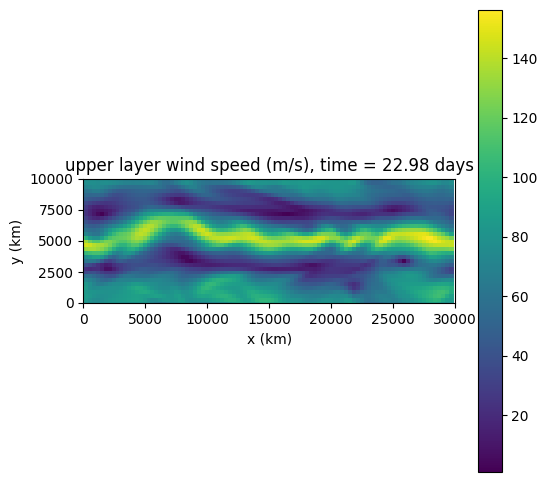

In [8]:
# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Describe the results in the box below. To what extent are the results qualitatively different from what you saw using the previous script? Comment on the interaction between the jet and the storms. Which features in the simulation do you think occur in the atmosphere? Do you see any features in the simulation that you think are unrealistic? If so, explain why you think those features are unrealistic.

ADD COMMENTS HERE (1-2 PARAGRAPHS). NO NEED FOR PLOTS, BUT YOU CAN INCLUDE THEM IF YOU WANT.

# 3. Forced QG flow

In the atmosphere, differential heating between the equator and poles maintains a north/south temperature gradient. This temperature gradient is represented by the north/south gradient in layer heights and potential vorticity in the 2-layer QG model. We can represent differential heating and cooling in the 2-layer QG model by adding terms that 'relax' the potential vorticity back to a prescribed field.

### 3.1 Student investigation
<a id='section3pt1'></a>

In the code box below, copy the code from Part 2 and modify it to include the following terms:
$$ \frac{\partial q_1}{\partial t} + \ldots = \ldots - \frac{1}{\tau}\left(q_1 - q_1(t=0)\right) $$

$$ \frac{\partial q_2}{\partial t} + \ldots = \ldots - \frac{1}{\tau}\left(q_2 - q_2(t=0)\right) $$

where $q_i(t=0)$ are the initial conditions (q1_ic and q2_ic in the script) and $\tau$ is a timescale which you should specify. A timescale of $\tau=36$ hours should be a good starting point. In the absence of any other terms, this additional forcing term will cause $q_1$ and $q_2$ to 'relax' exponentially back to the initial conditions with an e-folding timescale equal to $\tau$.

Climate change is expected to reduce the equator to pole temperature contrast as the high latitudes warm faster than the rest of the planet. This will have impacts on the intensity and dynamics of storms. Experiment with this by changing the pole to equator gradient in the prescribed initial potential vorticity. Specify which dimensional parameter you chose to vary and discuss how it relates to the north/south temperature gradient. What happens to the jet stream and the storms as you reduce the potential vorticity gradient?

In [5]:
# Copy and paste the code from section 2.1 here and modify to add the relaxation terms.
# Also, paste the code to visualize the results (or create a new code box below)

# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km #### change the Rds
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s #### U is an analogue for temperature gradient I think
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200
tau = 36 * 3600 #### change this bit

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1) - 1/tau * (q1-q1_ic)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2) - 1/tau * (q2-q2_ic)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)



INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 4s, Rate: 1.3e+01/s


2024-11-29 01:15:03,644 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 4s, Rate: 1.3e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 3s, Rate: 1.6e+01/s


2024-11-29 01:15:03,869 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 3s, Rate: 1.6e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 2s, Rate: 1.7e+01/s


2024-11-29 01:15:04,145 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 2s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 1.8e+01/s


2024-11-29 01:15:04,405 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 1.8e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 2s, Rate: 1.8e+01/s


2024-11-29 01:15:04,678 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 2s, Rate: 1.8e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 1.8e+01/s


2024-11-29 01:15:04,937 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 1.8e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 2s, Remaining: 1s, Rate: 1.8e+01/s


2024-11-29 01:15:05,205 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 2s, Remaining: 1s, Rate: 1.8e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 2s, Remaining: 1s, Rate: 1.8e+01/s


2024-11-29 01:15:05,473 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 2s, Remaining: 1s, Rate: 1.8e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 2s, Remaining: 0s, Rate: 1.8e+01/s


2024-11-29 01:15:05,747 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 2s, Remaining: 0s, Rate: 1.8e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 1.8e+01/s


2024-11-29 01:15:06,022 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 1.8e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 3s, Remaining: 0s, Rate: 1.8e+01/s


2024-11-29 01:15:06,205 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 3s, Remaining: 0s, Rate: 1.8e+01/s


INFO:__main__:Starting main loop


2024-11-29 01:15:06,328 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2024-11-29 01:15:06,782 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2024-11-29 01:15:07,407 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2024-11-29 01:15:08,027 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2024-11-29 01:15:08,639 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2024-11-29 01:15:09,270 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2024-11-29 01:15:10,153 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2024-11-29 01:15:10,730 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2024-11-29 01:15:11,362 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2024-11-29 01:15:11,976 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2024-11-29 01:15:12,597 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2024-11-29 01:15:13,223 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2024-11-29 01:15:13,849 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2024-11-29 01:15:14,486 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2024-11-29 01:15:15,135 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2024-11-29 01:15:15,777 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2024-11-29 01:15:16,414 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2024-11-29 01:15:17,178 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2024-11-29 01:15:18,183 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2024-11-29 01:15:19,157 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2024-11-29 01:15:20,166 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2024-11-29 01:15:20,892 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2024-11-29 01:15:21,526 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2024-11-29 01:15:22,142 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2024-11-29 01:15:22,753 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2024-11-29 01:15:23,384 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2024-11-29 01:15:24,006 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2024-11-29 01:15:24,677 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2024-11-29 01:15:25,315 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2024-11-29 01:15:25,953 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2024-11-29 01:15:26,574 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2024-11-29 01:15:27,191 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2024-11-29 01:15:27,833 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2024-11-29 01:15:28,496 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2024-11-29 01:15:29,105 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2024-11-29 01:15:29,752 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2024-11-29 01:15:30,386 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2024-11-29 01:15:31,355 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2024-11-29 01:15:32,343 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2024-11-29 01:15:33,382 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2024-11-29 01:15:34,246 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2024-11-29 01:15:34,864 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2024-11-29 01:15:35,476 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2024-11-29 01:15:36,120 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2024-11-29 01:15:36,741 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2024-11-29 01:15:37,394 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2024-11-29 01:15:38,005 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2024-11-29 01:15:38,617 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2024-11-29 01:15:39,235 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2024-11-29 01:15:39,896 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2024-11-29 01:15:40,526 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2024-11-29 01:15:41,167 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2024-11-29 01:15:41,784 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2024-11-29 01:15:42,414 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2024-11-29 01:15:43,054 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2024-11-29 01:15:43,689 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2024-11-29 01:15:44,540 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2024-11-29 01:15:45,507 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2024-11-29 01:15:46,486 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2024-11-29 01:15:47,540 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2024-11-29 01:15:48,192 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2024-11-29 01:15:48,861 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2024-11-29 01:15:49,495 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2024-11-29 01:15:50,100 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2024-11-29 01:15:50,719 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2024-11-29 01:15:51,334 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2024-11-29 01:15:52,161 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2024-11-29 01:15:52,782 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2024-11-29 01:15:53,392 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2024-11-29 01:15:54,014 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2024-11-29 01:15:54,820 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2024-11-29 01:15:55,442 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2024-11-29 01:15:56,091 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2024-11-29 01:15:56,727 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2024-11-29 01:15:57,338 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2024-11-29 01:15:58,204 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2024-11-29 01:15:59,173 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2024-11-29 01:16:00,178 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2024-11-29 01:16:01,211 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2024-11-29 01:16:01,854 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2024-11-29 01:16:02,475 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2024-11-29 01:16:03,098 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2024-11-29 01:16:03,731 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2024-11-29 01:16:05,308 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2024-11-29 01:16:06,450 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2024-11-29 01:16:07,071 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2024-11-29 01:16:07,723 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2024-11-29 01:16:08,365 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2024-11-29 01:16:09,014 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2024-11-29 01:16:09,651 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2024-11-29 01:16:10,311 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2024-11-29 01:16:10,927 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2024-11-29 01:16:11,805 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2024-11-29 01:16:12,803 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2024-11-29 01:16:13,799 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2024-11-29 01:16:14,814 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2024-11-29 01:16:15,443 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2024-11-29 01:16:16,070 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2024-11-29 01:16:16,709 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2024-11-29 01:16:17,348 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2024-11-29 01:16:17,993 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2024-11-29 01:16:19,067 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2024-11-29 01:16:20,795 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2024-11-29 01:16:22,529 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2024-11-29 01:16:23,214 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2024-11-29 01:16:23,864 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2024-11-29 01:16:24,489 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2024-11-29 01:16:25,354 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2024-11-29 01:16:26,330 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2024-11-29 01:16:27,364 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2024-11-29 01:16:28,384 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2024-11-29 01:16:29,009 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2024-11-29 01:16:29,637 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2024-11-29 01:16:30,284 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2024-11-29 01:16:30,911 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2024-11-29 01:16:31,566 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2024-11-29 01:16:32,218 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2024-11-29 01:16:32,861 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2024-11-29 01:16:33,516 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2024-11-29 01:16:34,166 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2024-11-29 01:16:34,811 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2024-11-29 01:16:35,459 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2024-11-29 01:16:36,092 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2024-11-29 01:16:36,711 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2024-11-29 01:16:37,345 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2024-11-29 01:16:37,948 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2024-11-29 01:16:38,748 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2024-11-29 01:16:39,731 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2024-11-29 01:16:40,737 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2024-11-29 01:16:41,717 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2024-11-29 01:16:41,721 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2024-11-29 01:16:41,725 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 3.012 sec


2024-11-29 01:16:41,727 solvers 0/1 INFO :: Setup time (init - iter 0): 3.012 sec


INFO:solvers:Warmup time (iter 0-10): 0.5398 sec


2024-11-29 01:16:41,729 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.5398 sec


INFO:solvers:Run time (iter 10-end): 94.66 sec


2024-11-29 01:16:41,731 solvers 0/1 INFO :: Run time (iter 10-end): 94.66 sec


INFO:solvers:CPU time (iter 10-end): 0.02629 cpu-hr


2024-11-29 01:16:41,733 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02629 cpu-hr


INFO:solvers:Speed: 1.904e+06 mode-stages/cpu-sec


2024-11-29 01:16:41,736 solvers 0/1 INFO :: Speed: 1.904e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-11-29 01:16:41,974 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp_rxf_q7q/temp.m4v


2024-11-29 01:16:41,980 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp_rxf_q7q/temp.m4v


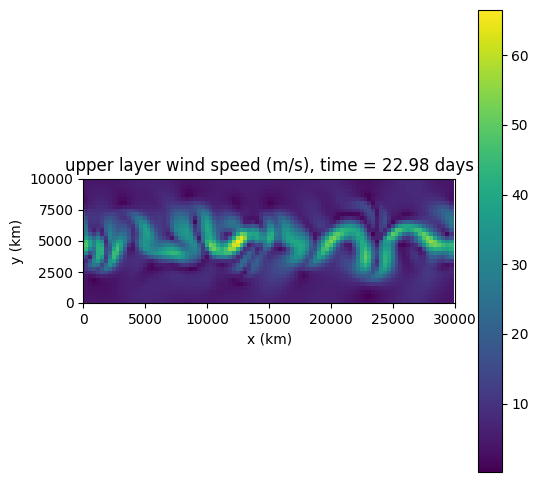

In [6]:
# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

INSERT COMMENTS HERE